# Behavioural Analysis for 'Imperceptible gamma-band sensory stimulation enhances episodic memory retrieval'

The following notebook runs the key analyses for 'Imperceptible gamma-band sensory stimulation enhances episodic memory retrieval'. The code and accompanying markdown aim to describe what is done and how it is accomplished. Note that both the participant-level logistic models and group-level statistics heavily involved 'for' loops. To help understand what is happening within these loops, one run of the loop is stepped through section-by-section, and then the loop is run in its entirety.

## Section 1: The Central Analyses
Here, we run the central analyses of the behavioural portion of the paper, using participant-specific logistic models and group-level one-sample t-tests to explore whether gamma-band sensory stimulation can boost recall.

### Section 1.1: Setting Up for the Main Analyses
First, import the relevant packages for the following analyses

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import platform
import ptitprince as pt
import scipy
import seaborn as sns
import statsmodels.api as sm
import sys

from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats import weightstats
from statsmodels.discrete import discrete_model as dm

# check python version is correct
p = sys.version_info
assert((p.major == 3) & (p.minor == 10) & (p.micro == 11))
del p

# cross-check package versions are correct
assert(mpl.__version__ == '3.7.1')  # matplotlib
assert(np.__version__ == '1.25.0')  # numpy
assert(pd.__version__ == '2.0.2')  # pandas
assert(scipy.__version__ == '1.11.0')  # scipy
assert(sns.__version__ == '0.11.0')  # seaborn
assert(sm.__version__ == '0.13.5')  # seaborn

# N.B. the package 'ptitprince' package should be version 0.2.6

With that done, we are ready to get started with the logistic models

### Section 1.2: Logistic Models: An Example
Here, we run through how the logistic model is computed for a single participant. First, we then define key parameters, including the directory where the data is stored, the flicker freqeuncies used in the two experiments, the outcome variables of interest, and the predictors of interest

In [2]:
# define key directories
if platform.system() == 'Windows':
    data_directory = 'C:/Users/griffibz/Dropbox/work_data/beh_gammaFlicker/'
else:
    data_directory = '/Users/ben/Dropbox/work_data/beh_gammaFlicker/'

# define flicker/model labels
flicker_freqs = [[65, 43, 33, 0],
                 [65, 0]]
labels_outcome = ['recalled', 'rt', 'confidence']
labels_frequency = ['{}Hz_{}'.format(n, s) for n in [33, 43, 65] for s in ['encoding', 'retrieval']]
labels_predictor = labels_frequency + ['rt', 'enc_onset', 'ret_onset', 'intercept']

Load the data

In [3]:
# load data
filename = '{}/dataset-01/log_pp01.csv'.format(data_directory)
data = pd.read_csv(filename)

# tidy
del filename

We then drop trials that have a missing response for video selection, confidence rating, or encoding question.

In [4]:
# identify trials with missing data
noMemoryResponse = data.rt.isnull()
noConfidenceResponse = data.confidence.isnull()

# drop trials with missing data
data = data.drop(index=np.where(noMemoryResponse | noConfidenceResponse)[0])
data = data.reset_index(drop=True)

# tidy
del noMemoryResponse, noConfidenceResponse

Memory performance is then computed by identifying trials for which both the video selection was correct and the participant reported that they did not guess their response.

In [5]:
# relabel 'recalled' in data structure as 'hit rate' (as this is a more appropriate term)
data['hit rate'] = data['recalled'].copy()

# re-code memory performance as pre-registered (i.e., trial is a hit, and reported to not be a guess)
data['recalled'] = (data.recalled == 1) & (data.confidence != 'Vergessen').astype('int')

The predictor variables are then prepared for the logistic models. This includes z-transforming linear measures of time to avoid fitting difficulties and dummy-coding every flicker condition.

In [6]:
# convert confidence ratings to binary (0 == guess/know, 1 == remember) [guesses will be excluded in this analysis]
data['confidence'] = (data['confidence'] == 'Erinnern').astype('int')

# z-score time-based parameters
data['rt'] = stats.zscore(data['rt'])
data['enc_onset'] = stats.zscore(data['enc_onset'])
data['ret_onset'] = stats.zscore(data['ret_onset'])

# dummy code flicker frequencies (excluding last value to avoid rank deficiency)
used_frequencies = []  # predefine list for regression predictors
for freq in np.arange(0, np.size(flicker_freqs[0]) - 1):
    for i, j in zip(['encoding', 'retrieval'], ['enc_freq', 'ret_freq']):
        label = '{}Hz_{}'.format(flicker_freqs[0][freq], i)  # define dataframe header
        data[label] = (data[j] == (freq + 1)).astype('int')  # get binary match to target freq
        used_frequencies.append(label)  # add label to predictor list
        del label, i, j
    del freq

# define predictors used in the model
predictors = used_frequencies + ['rt', 'enc_onset', 'ret_onset']

# tidy
del used_frequencies

The logistic model is then run using L1-regularised logistic regression. On occasion, the model will fail if there is insufficent hits/misses. To avoid issue here, a try/except segment is included. If the model fails, the t-values are returned as NaNs that will be excluded from further analysis.

In [7]:
# split data
y = data['recalled'].copy()
x = data[predictors].copy()

# add intercept
x['intercept'] = np.ones(np.size(x, 0))

# run L1-regularised logistic model
res = dm.Logit(y, x).fit_regularized(disp=False, method='l1')
t_values = res.tvalues.values

# return list of predictor labels
labels = list(x.columns)

# tidy
del y, x, res, t_values, labels, predictors, data

And that describes how a single-participant model is fit.

### Section 1.3: Running Logistic Models for All Participants
Before running the logistic model for all participants, we define a function that runs the regression for us. Additional functionality has been added here to (1) run a linear model when reaction time is used as the outcome variable, and (2) exclude forgotten trials when assessing reaction time/confidence.

In [8]:
# define logistic regression function
def run_regression(df, predvar, outvar, recalledOnly=False, useLogit=True):
    # df = dataframe of behavioural data
    # predvar = list of predictor variables matching column names of 'df'
    # outvar = string for outcome variable, matching column name of 'df'
    # recalledOnly = boolean, determines whether to run data solely on recalled data
    # useLogit = boolean, determines whether to run logistic or linear model

    # restrict to recalled only (if requested)
    if recalledOnly:
        df = df.loc[df['recalled'] == 1, :].reset_index(drop=True)

    # split data
    yi = df[outvar].copy()
    xi = df[predvar].copy()

    # add intercept
    xi['intercept'] = np.ones(np.size(xi, 0))

    # run logistic model
    if useLogit:
        try:
            r = dm.Logit(yi, xi).fit_regularized(disp=False, method='l1')
            t = r.tvalues.values
        except np.linalg.LinAlgError:
            r = []
            t = [np.nan] * (np.size(predictors) + 1)

    # else, run linear regression
    else:
        r = sm.OLS(yi, xi).fit()
        t = r.tvalues.values #res.params.values

    # get predictor labels
    s = list(xi.columns)

    # tidy and return
    del df, yi, xi, r, recalledOnly, useLogit, predvar, outvar
    return t, s

Define experiment-specific experiment details

In [9]:
# define number of participants/frequencies/models etc.
n_pp = [44, 36]
n_datasets = np.size(n_pp)
n_freqs = [np.size(n) for n in flicker_freqs]
n_outcomes = np.size(labels_outcome, 0)
n_predictors = np.size(labels_predictor, 0)

Dataframes for descriptive statistics (e.g., mean recall rate) and model outputs are predefined.

In [10]:
# create group descriptives structure
group_means = pd.DataFrame(index=np.arange(0, np.sum(n_pp)), columns=['dataset', 'pp', 'hit rate', 'recalled', 'rt'])

# add in dataset/participant/model number
group_means['dataset'] = np.concatenate([np.zeros(n_pp[i]) + i for i in np.arange(0, n_datasets)]).astype(int)
group_means['pp'] = np.concatenate([np.arange(0, n_pp[i]) for i in np.arange(0, n_datasets)])

# create group data structure
group_models = pd.DataFrame(index=np.arange(0, np.sum(n_pp) * n_outcomes * n_predictors),
                                columns=['dataset', 'pp', 'outcome', 'predictor', 'regressor_t', 'outlier'])

# add in dataset/participant/model number
group_models['dataset'] = np.concatenate(
    [np.zeros(n_pp[i] * n_outcomes * n_predictors) + i for i in np.arange(0, n_datasets)]).astype(int)
group_models['pp'] = np.concatenate(
    [np.repeat(np.arange(0, n_pp[i]), n_outcomes * n_predictors) for i in np.arange(0, n_datasets)])
group_models['outcome'] = np.tile(np.repeat(labels_outcome, n_predictors), sum(n_pp))
group_models['predictor'] = np.tile(labels_predictor, sum(n_pp) * n_outcomes)

Now, we run the big loop, fitting logistic models to each participant individually.

In [11]:
# cycle through datasets
for dataset in np.arange(0, n_datasets):

    # cycle through participants
    for pp in np.arange(0, n_pp[dataset]):

        # load data
        filename = '{}/dataset-{:02.0f}/log_pp{:02.0f}.csv'.format(data_directory, dataset + 1, pp + 1)
        data = pd.read_csv(filename)
        del filename

        # identify trials with missing data
        noMemoryResponse = data.rt.isnull()
        noConfidenceResponse = data.confidence.isnull()

        # drop trials with missing data
        data = data.drop(index=np.where(noMemoryResponse | noConfidenceResponse)[0])
        data = data.reset_index(drop=True)
        del noMemoryResponse, noConfidenceResponse

        # relabel 'recalled' in data structure as 'hit rate' (as this is a more appropriate term)
        data['hit rate'] = data['recalled'].copy()

        # re-code memory performance as pre-registered (i.e., trial is a hit, and reported to not be a guess)
        data['recalled'] = (data.recalled == 1) & (data.confidence != 'Vergessen').astype('int')

        # store descriptives
        idx = np.where((group_means['dataset'] == dataset) & (group_means['pp'] == pp))[0]
        group_means.loc[idx, 'hit rate'] = np.mean(data['hit rate'])
        group_means.loc[idx, 'recalled'] = np.mean(data['recalled'])
        group_means.loc[idx, 'rt'] = np.mean(data['rt'])
        del idx

        # convert confidence ratings to binary (0 == guess/know, 1 == remember) [guesses will be excluded in this analysis]
        data['confidence'] = (data['confidence'] == 'Erinnern').astype('int')

        # z-score time-based parameters
        data['rt'] = stats.zscore(data['rt'])
        data['enc_onset'] = stats.zscore(data['enc_onset'])
        data['ret_onset'] = stats.zscore(data['ret_onset'])

        # dummy code flicker frequencies (excluding last value to avoid rank deficiency)
        used_frequencies = []  # predefine list for regression predictors
        for freq in np.arange(0, np.size(flicker_freqs[dataset]) - 1):
            for i, j in zip(['encoding', 'retrieval'], ['enc_freq', 'ret_freq']):
                label = '{}Hz_{}'.format(flicker_freqs[dataset][freq], i)  # define dataframe header
                data[label] = (data[j] == (freq + 1)).astype('int')  # get binary match to target freq
                used_frequencies.append(label)  # add label to predictor list
                del label, i, j
            del freq

        # define additional regression variables
        covariates = [['rt', 'enc_onset', 'ret_onset'], ['enc_onset', 'ret_onset'], ['rt', 'enc_onset', 'ret_onset']]
        recalledOnly = [False, True, True]
        useLogit = [True, False, True]

        # cycle through outcomes
        for model in range(n_outcomes):

            # run logistic regression for memory recall
            predictors = used_frequencies + covariates[model]
            t_values, labels = run_regression(data, predictors, labels_outcome[model], recalledOnly[model], useLogit[model])

            # add regressor results to group data
            for i, j in zip(t_values, labels):
                row_index = np.where((group_models['dataset'] == dataset) &
                                     (group_models['pp'] == pp) &
                                     (group_models['outcome'] == labels_outcome[model]) &
                                     (group_models['predictor'] == j))[0]
                column_index = np.where(group_models.columns == 'regressor_t')[0]
                group_models.iloc[row_index, column_index] = i

                # tidy loop variables
                del row_index, column_index, i, j

            # tidy loop variables
            del predictors, t_values, labels, model

        # update user
        print('dataset-{:02.0f}, pp-{:02.0f} complete...'.format(dataset, pp))

        # tidy workspace
        del pp, covariates, recalledOnly, useLogit, data, used_frequencies

    # tidy workspace
    del dataset

dataset-00, pp-00 complete...
dataset-00, pp-01 complete...
dataset-00, pp-02 complete...
dataset-00, pp-03 complete...
dataset-00, pp-04 complete...
dataset-00, pp-05 complete...
dataset-00, pp-06 complete...
dataset-00, pp-07 complete...
dataset-00, pp-08 complete...
dataset-00, pp-09 complete...
dataset-00, pp-10 complete...
dataset-00, pp-11 complete...
dataset-00, pp-12 complete...
dataset-00, pp-13 complete...
dataset-00, pp-14 complete...
dataset-00, pp-15 complete...
dataset-00, pp-16 complete...
dataset-00, pp-17 complete...
dataset-00, pp-18 complete...
dataset-00, pp-19 complete...
dataset-00, pp-20 complete...
dataset-00, pp-21 complete...
dataset-00, pp-22 complete...
dataset-00, pp-23 complete...
dataset-00, pp-24 complete...
dataset-00, pp-25 complete...
dataset-00, pp-26 complete...
dataset-00, pp-27 complete...
dataset-00, pp-28 complete...
dataset-00, pp-29 complete...
dataset-00, pp-30 complete...
dataset-00, pp-31 complete...
dataset-00, pp-32 complete...
dataset-00

/Users/ben/.conda/envs/harmonic-flicker/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


dataset-01, pp-16 complete...
dataset-01, pp-17 complete...
dataset-01, pp-18 complete...
dataset-01, pp-19 complete...
dataset-01, pp-20 complete...
dataset-01, pp-21 complete...
dataset-01, pp-22 complete...
dataset-01, pp-23 complete...
dataset-01, pp-24 complete...
dataset-01, pp-25 complete...
dataset-01, pp-26 complete...
dataset-01, pp-27 complete...
dataset-01, pp-28 complete...
dataset-01, pp-29 complete...
dataset-01, pp-30 complete...
dataset-01, pp-31 complete...
dataset-01, pp-32 complete...
dataset-01, pp-33 complete...
dataset-01, pp-34 complete...
dataset-01, pp-35 complete...


### Section 1.4: An Example One-Sample T-Test
With the models run for every participant, it's time to run the group-level inferential statistics. First, we restrict the descriptives and model results to the relevant dataset, outcome variable and predictor

In [12]:
# get means for dataset
sub_means = group_means.query("dataset == 0").reset_index(drop=True)

# get data for dataset/model
sub_models = group_models.query("dataset == 0 and outcome == 'recalled' and predictor == '65Hz_retrieval'").reset_index(drop=True)

We then detect outliers based on memory performance (as pre-registered).

In [13]:
# prepare data
sub_models = sub_models.reset_index(drop=True)
sub_means = sub_means.reset_index(drop=True)
pp_count = np.size(sub_models, axis=0)
outliers = np.zeros(pp_count)  # predefine loop output

# sequentially cycle through memory based criteria for each participant
for pp in np.arange(0, pp_count):
    if sub_means['hit rate'][pp] < 0.3:
        outliers[pp] = 1
    elif sub_means['recalled'][pp] < 0.2:
        outliers[pp] = 2
    elif sub_means['recalled'][pp] > 0.8:
        outliers[pp] = 3
    del pp

# tidy up
del sub_means, pp_count

And subsequently detect MAD outliers, with floor/ceiling memory performers excluded (again, as pre-registered).

In [14]:
# extract values from data structure
values = sub_models['regressor_t'].values.astype('float')  # extract values for this regressor

# compute MAD outliers
non_outlier_idx = np.where(outliers == 0)[0]
non_outlier_values = values[non_outlier_idx]

if all(np.isnan(non_outlier_values)) == 0:  # skip if empty
    med = np.median(non_outlier_values)
    mad = stats.median_abs_deviation(non_outlier_values, scale='normal')
    mad_pps = ((non_outlier_values > (med + (mad * 3))) | (non_outlier_values < (med - (mad * 3)))).astype('int')
    mad_pps[mad_pps == 1] = 4
    outliers[non_outlier_idx] = mad_pps

# tidy workspace
del non_outlier_values, non_outlier_idx, med, mad, mad_pps

We then run the one-sample t-test, and add key values to the 'results' dataframe.

In [15]:
# get data of interest (excluding outliers)
values = sub_models['regressor_t'][outliers == 0].astype('float')

# run t-test
df = np.size(values, axis=0) - 1  # get degrees of freedom
t, p = stats.ttest_1samp(values, 0, alternative='two-sided')

# print row
print('65Hz > Baseline at Retrieval:\nt({:d}) = {:2.2f}, p = {:3.3f}'.format(int(df), t, p))

# tidy workspace
del values, sub_models, df, t, p

65Hz > Baseline at Retrieval:
t(33) = 3.22, p = 0.003


### Section 1.5: The Big Loop for Inferential Statistics
First, we define a function to detect all outlier types.

In [16]:
# identify MAD outliers
def detect_outliers(models_in, means_in):

    models_in = models_in.reset_index(drop=True)
    means_in = means_in.reset_index(drop=True)
    npps = np.size(models_in, axis=0)
    outliers_out = np.zeros(npps)  # predefine loop output
    vals = models_in['regressor_t'].values.astype('float')  # extract values for this regressor

    # sequentially cycle through memory based criteria for each participant
    for ppi in np.arange(0, npps):
        if means_in['hit rate'][ppi] < 0.3:
            outliers_out[ppi] = 1
        elif means_in['recalled'][ppi] < 0.2:
            outliers_out[ppi] = 2
        elif means_in['recalled'][ppi] > 0.8:
            outliers_out[ppi] = 3

    # compute MAD outliers
    non_out_idx = np.where(outliers_out == 0)[0]
    non_out_values = vals[non_out_idx]

    if all(np.isnan(non_out_values)) == 0:  # skip if empty
        medi = np.median(non_out_values)
        madi = stats.median_abs_deviation(non_out_values, scale='normal')
        mads = ((non_out_values > (medi + (madi * 3))) | (non_out_values < (medi - (madi * 3)))).astype('int')
        mads[mads == 1] = 4
        outliers_out[non_out_idx] = mads

    return outliers_out

Create a dataframe that will house the statistical results

In [17]:
# predefine statistics output
result_column_labels = ['dataset', 'outcome', 'predictor', 'mean', 'sem', 'd', 't', 'df', 'p', 'tost_pval', 'tost_tupp',
                        'tost_lupp']
results = pd.DataFrame(index=np.arange(0, n_datasets * n_outcomes * n_predictors), columns=result_column_labels)
results['outcome'] = np.repeat(labels_outcome, n_predictors * n_datasets)
results['dataset'] = np.tile(np.concatenate([np.zeros(n_predictors) + i for i in np.arange(0, n_datasets)]),
                             n_outcomes).astype(int)
results['predictor'] = np.tile(labels_predictor, n_datasets * n_outcomes)
del result_column_labels

# define side of tail
tail = ['two-sided', 'greater']

Then, we run our big loop.

In [18]:
# cycle through datasets
for dataset in np.arange(0, n_datasets):

    # get means for dataset
    sub_means = group_means.query("dataset == {}".format(dataset)).reset_index(drop=True)

    # cycle through outcomes and predictors
    for outcome in labels_outcome:
        for predictor in labels_predictor:

            # get data for dataset/model
            mod_query = "dataset == {} and outcome == '{}' and predictor == '{}'".format(dataset, outcome, predictor)
            sub_models = group_models.query(mod_query).reset_index(drop=True)
            del mod_query

            # skip if all values are NaN
            if all(np.isnan(sub_models['regressor_t'].values.astype('float'))): # skip if empty
                continue

            # detect outliers based on pre-registered criteria
            outliers = detect_outliers(sub_models, sub_means)

            # add outliers column to group data
            idx = np.where((group_models['dataset'] == dataset) & (group_models['outcome'] == outcome) & \
                           (group_models['predictor'] == predictor))[0]
            group_models.loc[idx, 'outlier'] = outliers.astype('int')
            del idx

            # get data of interest
            values = sub_models['regressor_t'][outliers == 0].dropna().astype('float')
            del sub_models, outliers

            # get index in results DataFrame
            row_index = np.where((results['dataset'] == dataset) & (results['outcome'] == outcome) &
                                 (results['predictor'] == predictor))[0]

            # get regressor descriptives
            results.loc[row_index, 'mean'] = np.round(np.mean(values), 2)
            results.loc[row_index, 'sem'] = np.round(np.std(values) / np.sqrt(np.size(values)), 2)
            results.loc[row_index, 'd'] = np.round(np.mean(values) / np.std(values), 2)

            # run t-test
            results.loc[row_index, 'df'] = np.size(values, axis=0) - 1  # get degrees of freedom
            results.loc[row_index, 't'], results.loc[row_index, 'p'] = stats.ttest_1samp(values, 0,
                                                                                         alternative=tail[dataset])

            # reduce significant figures
            results.loc[row_index, 't'] = np.round(results.loc[row_index, 't'].astype('float'), 2)
            results.loc[row_index, 'p'] = np.round(results.loc[row_index, 'p'].astype('float'), 3)

            # correct p-values in dataset 1 to account for exploration
            if (dataset == 0) & (predictor[2:4] == 'Hz'):
                results.loc[row_index, 'p'] = results.loc[row_index, 'p']*6
                if results.loc[row_index, 'p'].values.astype('float') > 1:
                    results.loc[row_index, 'p'] = 1

            # run TOST
            thr = np.std(values) * 0.5
            [p, t1, t2] = weightstats.ttost_paired(values, np.zeros(np.size(values)), -thr, thr)
            results.loc[row_index, 'tost_pval'] = np.round(p, 3)
            results.loc[row_index, 'tost_tupp'] = np.round(t1[0], 2)
            results.loc[row_index, 'tost_lupp'] = np.round(t2[0], 2)
            del p, t1, t2, thr, predictor, row_index, values
        del outcome
    del sub_means, dataset

# drop contrasts with NaN results
results = results.dropna(axis=0, how='any', inplace=False)
results = results.reset_index(drop=True, inplace=False)
del tail

Then, we can print our results and see what we have.

In [19]:
print(results.drop(['mean', 'sem', 'tost_pval', 'tost_lupp', 'tost_tupp'], axis=1))
print(results.drop(['mean', 'sem', 'd', 't', 'df', 'p'], axis=1))

    dataset     outcome       predictor     d      t  df      p
0         0    recalled   33Hz_encoding  -0.1  -0.56  34      1
1         0    recalled  33Hz_retrieval  0.87   5.08  34    0.0
2         0    recalled   43Hz_encoding  0.15   0.86  34      1
3         0    recalled  43Hz_retrieval -0.14  -0.84  34      1
4         0    recalled   65Hz_encoding -0.01  -0.07  34      1
5         0    recalled  65Hz_retrieval  0.56   3.22  33  0.018
6         0    recalled              rt -2.31 -13.46  34    0.0
7         0    recalled       enc_onset  0.85   4.93  34    0.0
8         0    recalled       ret_onset -0.81   -4.7  34    0.0
9         0    recalled       intercept  0.58   3.38  34  0.002
10        1    recalled   65Hz_encoding -0.12  -0.62  28   0.73
11        1    recalled  65Hz_retrieval  0.42   2.21  28  0.018
12        1    recalled              rt -2.49 -13.17  28    1.0
13        1    recalled       enc_onset  0.72   3.83  28    0.0
14        1    recalled       ret_onset 

Lastly, we save the data.

In [20]:
# save table
group_means.to_csv('{}/data_groupMeans.csv'.format(data_directory))
group_models.to_csv('{}/data_groupModels.csv'.format(data_directory))
results.to_csv('{}/data_groupResults.csv'.format(data_directory))

### Section 1.6: Plotting the Data
Here, we plot figure 1b and a few additional plots of the RT and confidence data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


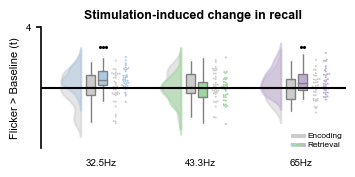

In [21]:
# set pyplot defaults
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 1.5

# set local defaults
img_style = {'title': dict(fontsize=9, fontweight='bold'),
             'axlabel': dict(fontsize=8),
             'ticklabel': dict(fontsize=7, color='black')}

# define inches-to-cm ration
cm = 1 / 2.54

# cycle through each condition
for predictor in group_models['predictor'].unique():
    for dataset in group_models['dataset'].unique():

        # detect outliers and add to dataframe
        models_index = np.where((group_models['dataset'] == dataset) & (group_models['outcome'] == 'recalled') &
                                (group_models['predictor'] == predictor))[0]
        means_index = np.where(group_means['dataset'] == dataset)[0]
        group_models.loc[models_index, 'outlier'] = detect_outliers(group_models.loc[models_index, :],
                                                                    group_means.loc[means_index, :]).astype('int')
        del models_index, means_index, dataset
    del predictor

# convert types to work w/ pritprince
group_models['dataset'] = group_models['dataset'].astype('category')

# define colours
pastels = np.array([[172, 202, 226], [157, 215, 157], [190, 173, 211]]) / 255
enc_ret_pastels = np.vstack(([0.8, 0.8, 0.8], pastels[0, :], [0.8, 0.8, 0.8],
                             pastels[1, :], [0.8, 0.8, 0.8], pastels[2, :]))
enc_ret_palette = dict([(0, np.array([0.8, 0.8, 0.8])),
                        (1, pastels[0, :]),
                        (2, np.array([0.8, 0.8, 0.8])),
                        (3, pastels[1, :]),
                        (4, np.array([0.8, 0.8, 0.8])),
                        (5, pastels[2, :])])
dataset_palette = [[], []]
dataset_palette[0] = dict([(0, np.array([0.8, 0.8, 0.8])),
                           (1, np.array([0.8, 0.8, 0.8])),
                           (2, np.array([0.8, 0.8, 0.8]))])
dataset_palette[1] = dict([(0, pastels[0, :]),
                           (1, pastels[1, :]),
                           (2, pastels[2, :])])

# create restricted dataframe
frequencies = [33, 43, 65]
df_all = [[], [], []]
for i in [0, 1, 2]:
    enc_label = str(frequencies[i]) + 'Hz_encoding'
    ret_label = str(frequencies[i]) + 'Hz_retrieval'
    labels = [enc_label, ret_label]
    idx = np.where(((group_models['predictor'] == enc_label) | (group_models['predictor'] == ret_label)) &
                   (group_models['outcome'] == 'recalled') & (group_models['dataset'] == 0))[0]
    df = group_models.loc[idx, :].copy()
    df['predictor'] = (df['predictor'] == labels[1]).astype('int') + (2*i)
    df['dataset'] = np.floor(df['predictor']/2).astype('int')
    df_all[i] = df.loc[df['outlier'] == 0, :]
    del df, enc_label, ret_label, labels, idx, i

df = pd.concat(df_all)
df = df.reset_index(drop=True)
df['predictor'] = df['predictor'].astype('category')
df['dataset'] = df['dataset'].astype('category')
df['regressor_t'] = df['regressor_t'].astype('float')
df = df.dropna(axis=0)
del frequencies, df_all

# plot violin
f, ax = plt.subplots(figsize=(10*cm, 4*cm))
for i in np.arange(0, 6):

    # get violin dataset
    tmp = df.loc[df['predictor'] == i, :]
    pt.half_violinplot(x='dataset', y='regressor_t', data=tmp, bw=0.4, scale="area", width=0.4, inner=None,
                       orient='v', ax=ax, dodge=False, saturation=1)
    ax.collections[-1].set_color(enc_ret_pastels[i, :])
    ax.collections[-1].set_alpha(0.5)
    del tmp

    # plot boxplot
    xpos = np.floor(i/2) + ((i % 2)*0.12) - 0.05
    plt.boxplot(df.loc[df['predictor'] == i, 'regressor_t'], positions=[xpos], widths=0.09, whis=100,
                patch_artist=True, boxprops=dict(facecolor=enc_ret_pastels[i, :], edgecolor=[0.5, 0.5, 0.5], linewidth=1),
                whiskerprops=dict(color=[0.5, 0.5, 0.5], linewidth=1), medianprops=dict(color=[0.5, 0.5, 0.5], linewidth=1),
                capprops=dict(color=[1, 1, 1], linewidth=1))

    # plot significance
    if i == 5:
        ax.scatter([xpos-0.015, xpos+0.015], [2.65, 2.65], marker='*', s=2, color='black')
    elif i == 1:
        ax.scatter([xpos-0.03, xpos, xpos+0.03], [2.65, 2.65, 2.65], marker='*', s=2, color='black')
    del xpos

    # plot scatter
    num_items = len(ax.collections)
    tmp = df.loc[df['predictor'] == i, :]
    sns.swarmplot(x='dataset', y='regressor_t', data=tmp, ax=ax, size=1.4, palette=dataset_palette[(i % 2)])
    for item in ax.collections[num_items:]:
        offsets = item.get_offsets()
        offsets[:, 0] = offsets[:, 0] + 0.2 + ((i % 2) * 0.1)
        item.set_offsets(offsets)

    # tidy up
    del item, tmp, offsets, num_items, i

# add custom legend
x = 1.95
y1 = -3.3
y2 = -3.9
rectangle = plt.Rectangle((x, y1), 0.15, 0.25, facecolor=enc_ret_pastels[0, :])
ax.add_patch(rectangle)
ax.text(x=x+.17, y=y1, s='Encoding', **dict(fontsize=6))
p = plt.Polygon(np.array([[x, y2], [x+.075, y2+.25], [x, y2+.25]]), closed=False, facecolor=enc_ret_pastels[1, :])
ax.add_patch(p)
p = plt.Polygon(np.array([[x, y2], [x+.075, y2], [x+.15, y2+.25], [x+.075, y2+.25]]), closed=False,
                facecolor=enc_ret_pastels[3, :])
ax.add_patch(p)
p = plt.Polygon(np.array([[x+.075, y2], [x+.15, y2+.25], [x+.15, y2]]), closed=False, facecolor=enc_ret_pastels[5, :])
ax.add_patch(p)
ax.text(x=x+.17, y=y2, s='Retrieval', **dict(fontsize=6))

# pretty up plot
ax.plot([-0.55, 2.5], [0, 0], color='black', zorder=100)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_linewidth(1.2)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', width=1.2)
ax.set_xlim(-0.55, 2.5)
ax.set_ylim([-4, 4])
yticks = np.arange(4, 4.1).astype('int')
ax.set_yticks(yticks)
str_ticks = yticks.astype('str')
for t in np.arange(0, np.size(str_ticks)):
    if (str_ticks[t] != '-4') and (str_ticks[t] != '4') and (str_ticks[t] != '0'):
        str_ticks[t] = ''
ax.set_yticklabels(str_ticks, **img_style['ticklabel'])
ax.set_xticks(np.arange(0.05, 2.2, 1))
ax.set_xticklabels(['32.5Hz', '43.3Hz', '65Hz'], **img_style['ticklabel'])
ax.set_xlabel('')
ax.set_ylabel('Flicker > Baseline (t)', **img_style['axlabel'])
ax.set_title('Stimulation-induced change in recall', pad=6, **img_style['title'])
plt.savefig("{}/figures/exp1_recalled_performance.eps".format(data_directory), dpi=500,
            bbox_inches='tight', pad_inches=0, facecolor=[1, 1, 1])

# tidy up
del f, ax, t, str_ticks, yticks, p, rectangle, x, y1, y2, df

We can then plot figure 1E.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


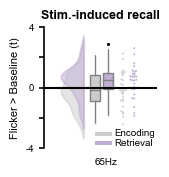

In [22]:
# define colours
pastels = np.array([[190, 173, 211], [249, 202, 159], [218, 169, 182]]) / 255
enc_ret_pastels = np.vstack(([0.8, 0.8, 0.8], pastels[0, :], [0.8, 0.8, 0.8],
                             pastels[1, :], [0.8, 0.8, 0.8], pastels[2, :]))
enc_ret_palette = dict([(0, np.array([0.8, 0.8, 0.8])),
                        (1, pastels[0, :]),
                        (2, np.array([0.8, 0.8, 0.8])),
                        (3, pastels[1, :]),
                        (4, np.array([0.8, 0.8, 0.8])),
                        (5, pastels[2, :])])
dataset_palette = [[], []]
dataset_palette[0] = dict([(0, np.array([0.8, 0.8, 0.8])),
                           (1, np.array([0.8, 0.8, 0.8])),
                           (2, np.array([0.8, 0.8, 0.8]))])
dataset_palette[1] = dict([(0, pastels[0, :]),
                           (1, pastels[1, :]),
                           (2, pastels[2, :])])


# create restricted dataframe
idx = np.where(((group_models['predictor'] == '65Hz_encoding') | (group_models['predictor'] == '65Hz_retrieval')) &
               (group_models['outcome'] == 'recalled') & (group_models['dataset'] == 1))[0]
df = group_models.loc[idx, :].copy()
df['predictor'] = (df['predictor'] == '65Hz_retrieval').astype('int')
df['dataset'] = np.floor(df['predictor']/2).astype('int')
df = df.loc[df['outlier'] == 0, :]
df = df.reset_index(drop=True)
df['predictor'] = df['predictor'].astype('category')
df['dataset'] = df['dataset'].astype('category')
df['regressor_t'] = df['regressor_t'].astype('float')
df = df.dropna(axis=0)
del idx

# plot violin
f, ax = plt.subplots(figsize=(3.7*cm, 4*cm))
for i in np.arange(0, 2):

    # get violin dataset
    tmp = df.loc[df['predictor'] == i, :]
    pt.half_violinplot(x='dataset', y='regressor_t', data=tmp, bw=0.4, scale="area", width=0.4, inner=None,
                       orient='v', ax=ax, dodge=False, saturation=1)
    ax.collections[-1].set_color(enc_ret_pastels[i, :])
    ax.collections[-1].set_alpha(0.5)

    xpos = np.round(np.floor(i/2) + ((i % 2)*0.12) - 0.05, decimals=2)
    plt.boxplot(df.loc[df['predictor'] == i, 'regressor_t'], positions=[xpos], widths=0.09, whis=100,
                patch_artist=True, boxprops=dict(facecolor=enc_ret_pastels[i, :], edgecolor=[0.5, 0.5, 0.5], linewidth=1),
                whiskerprops=dict(color=[0.5, 0.5, 0.5], linewidth=1), medianprops=dict(color=[0.5, 0.5, 0.5], linewidth=1),
                capprops=dict(color=[1, 1, 1], linewidth=1))

    # plot significance
    if i == 1:
        ax.scatter([xpos], [2.9], marker='*', s=2, color='black')

    # plot scatter
    num_items = len(ax.collections)
    sns.swarmplot(x='dataset', y='regressor_t', data=tmp, ax=ax, size=1.4, palette=dataset_palette[(i % 2)])
    for item in ax.collections[num_items:]:
        offsets = item.get_offsets()
        offsets[:, 0] = offsets[:, 0] + 0.2 + ((i % 2) * 0.1)
        item.set_offsets(offsets)
        del item, offsets

    # tidy workspace
    del tmp, num_items, i, xpos

# add custom legend
x = -0.05
y1 = -3.2
y2 = -3.8
rectangle = plt.Rectangle((x, y1), 0.15, 0.25, facecolor=enc_ret_pastels[0, :])
ax.add_patch(rectangle)
ax.text(x=x+.17, y=y1, s='Encoding', **dict(fontsize=7))
rectangle = plt.Rectangle((x, y2), 0.15, 0.25, facecolor=enc_ret_pastels[1, :])
ax.add_patch(rectangle)
ax.text(x=x+.17, y=y2, s='Retrieval', **dict(fontsize=7))

ax.plot([-0.55, 0.5], [0, 0], color='black', zorder=100)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_linewidth(1.2)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', width=1.2)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim([-4, 4])
ax.set_yticks(np.arange(-4, 4.1, 2))
ax.set_yticklabels(['-4', '', '0', '', '4'], **img_style['ticklabel'])
ax.set_xticks([0.05])
ax.set_xticklabels(['65Hz'], **img_style['ticklabel'])
ax.set_xlabel('')
ax.set_ylabel('Flicker > Baseline (t)', **img_style['axlabel'])
ax.set_title('Stim.-induced recall', pad=6,**img_style['title'])
plt.savefig("{}/figures/exp2_performance.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0, facecolor=[1, 1, 1])

# tidy workspace
del f, ax, rectangle, x, y1, y2, df

And figure 1c...

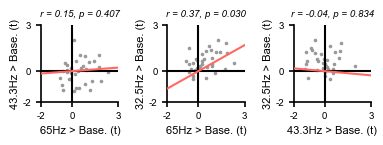

In [23]:
# cycle through each condition
for predictor in group_models['predictor'].unique():
    for dataset in group_models['dataset'].unique():

        # detect outliers and add to dataframe
        models_index = np.where((group_models['dataset'] == dataset) & (group_models['outcome'] == 'recalled') &
                                (group_models['predictor'] == predictor))[0]
        means_index = np.where(group_means['dataset'] == dataset)[0]
        group_models.loc[models_index, 'outlier'] = detect_outliers(group_models.loc[models_index, :],
                                                                    group_means.loc[means_index, :]).astype('int')
        del dataset, models_index, means_index
    del predictor

# create restricted dataframe
frequencies = [65, 43, 33]
df_all = [[], [], []]
for i in [0, 1, 2]:
    ret_label = str(frequencies[i]) + 'Hz_retrieval'
    idx = np.where((group_models['predictor'] == ret_label) & (group_models['outcome'] == 'recalled') & (group_models['dataset'] == 0))[0]
    df = group_models.loc[idx, :].copy()
    df_all[i] = df
    del df, ret_label, idx, i

# combine dataframe and drop outliers
df = pd.concat(df_all)
good_pps = []
for pp in np.unique(df['pp']):
    good_pps.append(all(df.loc[df['pp'] == pp, 'outlier'] == 0))
df = df.loc[np.tile(good_pps, 3), :].reset_index(drop=True)
del df_all, good_pps, pp

# cycle through pairings
freqs_df = ['65', '43', '33']
freqs_true = ['65', '43.3', '32.5']
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10*cm, 4*cm))
f.set_tight_layout(True)
count = 0
for xi in np.arange(0, np.size(freqs_df)):
    for yi in np.arange(xi+1, np.size(freqs_df)):

        # get df
        x = df.loc[df.predictor == freqs_df[xi] + 'Hz_retrieval', 'regressor_t']
        y = df.loc[df.predictor == freqs_df[yi] + 'Hz_retrieval', 'regressor_t']

        # get correlation + line of best fit
        r, p = stats.pearsonr(x, y)
        res = sm.OLS(y.to_list(), x.to_list()).fit()
        lob = [-2, 3] * res.params

        # plot correlation
        ax[count].scatter(x, y, s=2.5, facecolor=[0.6, 0.6, 0.6])
        ax[count].set_aspect('equal', 'box')
        ax[count].plot([-2, 3], lob, color=[1, 0.41, 0.38], zorder=100)
        ax[count].plot([0, 0], [-2, 3], color='black')
        ax[count].plot([-2, 3], [0, 0], color='black')
        ax[count].set_xlim([-2, 3])
        ax[count].set_ylim([-2, 3])
        ax[count].spines.right.set_visible(False)
        ax[count].spines.top.set_visible(False)
        ax[count].spines.left.set_linewidth(1.2)
        ax[count].spines.bottom.set_linewidth(1.2)
        ax[count].tick_params(axis='both', width=1.2)
        ax[count].set_xticks([-2, 0, 3])
        ax[count].set_yticks([-2, 0, 3])
        ax[count].set_xticklabels(['-2', '0', '3'], **img_style['ticklabel'])
        ax[count].set_yticklabels(['-2', '0', '3'], **img_style['ticklabel'])
        ax[count].set_ylabel(str(freqs_true[yi]) + 'Hz > Base. (t)', labelpad=2, **img_style['axlabel'])
        ax[count].set_xlabel(str(freqs_true[xi]) + 'Hz > Base. (t)', labelpad=3, **img_style['axlabel'])
        ax[count].set_title('r = {:2.2f}, p = {:3.3f}'.format(r, p),
                            **dict(fontsize=img_style['axlabel']['fontsize']-1, fontstyle='italic'))
        count += 1
        del yi, x, y, r, p, res, lob
    del xi

plt.savefig("{}/figures/exp1_correlations.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            facecolor=[1, 1, 1])

# tidy up
del f, ax, count, freqs_true, freqs_df, df, frequencies

Tidy workspace

In [24]:
del cm, dataset_palette, enc_ret_palette, enc_ret_pastels, pastels, results, img_style
del labels_frequency, labels_outcome, labels_predictor, n_datasets, n_freqs, n_outcomes, n_pp, n_predictors, group_means, \
    group_models, flicker_freqs

## Section 2: Raw Performance
In this section, we aim to conceptually replicate the results of Section 1 using raw memory performance in place of participant-specific logistic models.

We begin by (re-)defining a few key parameters and creating a dataframe that will retain behavioural performance of each participant

In [25]:
# define flicker/model labels
flicker_freqs = [[65, 43, 33, 0],
                 [65, 0]]

# define number of participants/frequencies/models etc.
n_datasets = 2
n_pp = [44, 36]

# create group descriptives structure
group_means = pd.DataFrame(index=np.arange(0, np.sum(n_pp)),
                               columns=['dataset', 'pp', 'recalled_65Hz', 'recalled_43Hz', 'recalled_33Hz', 'outlier'])

# add in dataset/participant/model number
group_means['dataset'] = np.concatenate([np.zeros(n_pp[i]) + i for i in np.arange(0, n_datasets)]).astype(int)
group_means['pp'] = np.concatenate([np.arange(0, n_pp[i]) for i in np.arange(0, n_datasets)])

Next, we re-run our big loop. This time, however, the logistic models are replaced by a simple loop that computes mean recall performance given the flicker at retrieval, which is then scaled based on baseline performance.

In [26]:
# cycle through datasets
count = 0
for dataset in np.arange(0, n_datasets):

    # cycle through participants
    for pp in np.arange(0, n_pp[dataset]):

        # load data
        filename = '{}/dataset-{:02.0f}/log_pp{:02.0f}.csv'.format(data_directory, dataset + 1, pp + 1)
        data = pd.read_csv(filename)
        outlier = 0
        del filename

        # identify trials with missing data
        noMemoryResponse = data.rt.isnull()
        noConfidenceResponse = data.confidence.isnull()

        # drop trials with missing data
        data = data.drop(index=np.where(noMemoryResponse | noConfidenceResponse)[0])
        data = data.reset_index(drop=True)
        del noMemoryResponse, noConfidenceResponse

        # determine <30% outliers
        if np.mean(data['recalled']) <= 0.3:
            outlier = 1

        # re-code memory performance as pre-registered (i.e., trial is a hit, and reported to not be a guess)
        data['recalled'] = (((data.recalled == 1) & (data.confidence != 'Vergessen'))).astype('int')

        # determine <20% / >80% outliers
        if (np.mean(data['recalled']) <= 0.2) | (np.mean(data['recalled']) >= 0.8):
            outlier = 1

        # cycle through each frequency
        n_freqs = np.size(flicker_freqs[dataset])
        baseline = np.sum(data.loc[data['ret_freq']==n_freqs, 'recalled'])
        for freq in np.arange(0, np.size(flicker_freqs[dataset])-1):
            colstr = ['recalled_' + str(flicker_freqs[dataset][freq]) + 'Hz']
            group_means.loc[count, colstr] = (np.sum(data.loc[data['ret_freq']==(freq+1), 'recalled']) - baseline) / baseline
            del colstr, freq
        del n_freqs, baseline

        # add in outlier info
        group_means.loc[count, 'outlier'] = outlier
        del outlier

        # update counter
        count += 1

        # tidy up
        del pp, data
    del dataset
del count

We can then run the statistics in the same manner as before.

In [27]:
# predefine statistics output
result_column_labels = ['dataset', 'predictor', 'mean', 'sem', 'd', 't', 'df', 'p']
results = pd.DataFrame(index=np.arange(0, n_datasets * 3),
                           columns=result_column_labels)
results['dataset'] = [0, 0, 0, 1, 1, 1]
results['predictor'] = np.tile(['33Hz', '43Hz', '65Hz'], n_datasets)
del result_column_labels

# cycle through datasets
tail = ['two-sided', 'greater']
for dataset in np.arange(0, n_datasets):

    # cycle through frequencies
    for freq in ['33Hz', '43Hz', '65Hz']:

        # get index of condition
        row_index = np.where((results['dataset'] == dataset) & (results['predictor'] == freq))[0]

        # get pct change values
        values = group_means.loc[(group_means['dataset'] == dataset) & (group_means['outlier'] == 0), 'recalled_'+freq].values.astype('float')

        # compute MAD outliers
        med = np.median(values)
        mad = stats.median_abs_deviation(values, scale='normal')
        good_pps = ((values > (med + (mad * 3))) | (values < (med - (mad * 3)))) == False
        values = values[good_pps]
        del good_pps, med, mad

        # get regressor descriptives
        results.loc[row_index, 'mean'] = np.mean(values)
        results.loc[row_index, 'sem'] = np.std(values) / np.sqrt(np.size(values))
        results.loc[row_index, 'd'] = np.mean(values) / np.std(values)

        # run t-test
        results.loc[row_index, 'df'] = np.size(values, axis=0) - 1  # get degrees of freedom
        results.loc[row_index, 't'], results.loc[row_index, 'p'] = stats.ttest_1samp(values, 0, alternative=tail[dataset])

        # correct test if exp. 1
        if dataset == 0:
            results.loc[row_index, 'p'] = results.loc[row_index, 'p']*6

        # tidy workspace
        del freq, values, row_index
    del dataset

# drop contrasts with NaN results
results = results.dropna(axis=0, how='any', inplace=False)
results = results.reset_index(drop=True, inplace=False)

# print results
results

,dataset,predictor,mean,sem,d,t,df,p
0,0,33Hz,0.0877,0.023115,0.650679,3.737864,33,0.00422
1,0,43Hz,-0.026427,0.020485,-0.221247,-1.270966,33,1.275764
2,0,65Hz,0.058079,0.019325,0.523185,2.959579,32,0.034546
3,1,65Hz,0.058094,0.018812,0.573438,3.034351,28,0.002579


Tidy up workspace

In [28]:
# tidy up
del flicker_freqs, group_means, n_datasets, n_pp, results, tail

Thus ends the section.

## Section 3: Flicker Perception
In this section, the first two experiments are analysed to see if participants could detect the flickering screens. As the way the perception tasks were set up for the two experiments are fundamentally different, the analyses are conducted separately too.

### Section 3.1: Analysis Example
We begin with a single participant example. Below, we read in the data and drop the missing trials.

In [29]:
# define participant
pp = 10

# load data
filename = '{}/dataset-01/perception_pp{:02.0f}.csv'.format(data_directory, pp + 1)
data = pd.read_csv(filename)
del pp, filename

# drop nans
data = data.dropna(axis=0, how='any')
data = data.reset_index(drop=True)

In this example, we then compare 65Hz to the no-flicker condition and determine mean accuracy as the percentage of times when the participants correctly deduced whether the screen was flickering or not. To determine if performance was significantly greater than chance for a given participant, we shuffle the data and re-compute perceptual accuracy to build a distribution of performances expected by chance, and then compare the observed perceptual performance to this distribution. Detection (i.e., the proportion of times when a participant reported a flickering screen given that the screen was flickering) is also computed for later visualisation.

In [30]:
# get indices of static + frequency-of-interest conditions
idx = (data.flicker_condition == 4) | (data.flicker_condition == 1)

# get accuracy
x = data.screenActuallyFlickers[idx].reset_index(drop=True)
y = data.ppThinksItFlickers[idx].reset_index(drop=True)
accuracy = np.mean(x == y)

# get p-value
n_perms = 500
accuracy_distribution = np.zeros(n_perms)
for n in np.arange(0, n_perms):
    accuracy_distribution[n] = np.mean(x == y.iloc[np.random.permutation(len(y))].reset_index(drop=True))
    del n
p = 1 - (sum(accuracy > accuracy_distribution) / n_perms)

# get detection percentage (i.e., number of items participant correctly detected the flickering screen)
detection = np.sum(y[x == 1]) / np.sum([x == 1])

# print results
print('Percentage of 65Hz Flickers Detected: ~{:d}%'.format(int(detection*100)))
print('Significance: p = {:03.3f}'.format(p))

Percentage of 65Hz Flickers Detected: ~6%
Significance: p = 0.508


Tidy workspace

In [31]:
del idx, x, y, n_perms, accuracy_distribution, accuracy, p, detection, data

### Section 3.2: Perception in Experiment 1
The code below runs the perceptual analysis (as described in section 3.1) for all participants and all flicker frequencies.

In [32]:
# define group data frame
n_pp = [44, 36]
group_data = [[], []]
group_data[0] = pd.DataFrame(data=np.zeros((n_pp[0], 9)),
                                 columns=['65Hz_acc', '43Hz_acc', '32Hz_acc', '65Hz_p', '43Hz_p', '32Hz_p',
                                          '65Hz_detect', '43Hz_detect', '32Hz_detect'])
missing_pps = np.zeros(n_pp[0])

# cycle through participants
for pp in np.arange(0, n_pp[0]):

    # skip participants w/o recorded frequencies and missing participants
    if (pp < 4) | ((pp > 33) & (pp < 40)):
        missing_pps[pp] = 1
        continue

    # load data
    filename = '{}/dataset-01/perception_pp{:02.0f}.csv'.format(data_directory, pp + 1)
    data = pd.read_csv(filename)

    # drop nans
    data = data.dropna(axis=0, how='any')
    data = data.reset_index(drop=True)

    # cycle through three frequency conditions
    accuracy = [np.nan] * 3
    p = [np.nan] * 3
    detection = [np.nan] * 3
    for i in np.arange(0, 3):

        # get indices of static + frequency-of-interest conditions
        idx = (data.flicker_condition == 4) | (data.flicker_condition == i + 1)

        # get accuracy
        x = data.screenActuallyFlickers[idx].reset_index(drop=True)
        y = data.ppThinksItFlickers[idx].reset_index(drop=True)
        accuracy[i] = np.mean(x == y)

        # get p-value
        n_perms = 500
        accuracy_distribution = np.zeros(n_perms)
        for n in np.arange(0, n_perms):
            accuracy_distribution[n] = np.mean(x == y.iloc[np.random.permutation(len(y))].reset_index(drop=True))
        p[i] = 1 - (sum(accuracy[i] > accuracy_distribution) / n_perms)

        # get detection percentage
        detection[i] = np.sum(y[x == 1]) / np.sum([x == 1])

        # tidy
        del idx, x, y, n_perms, accuracy_distribution, n

    # add results to group data
    group_data[0].loc[pp, :] = np.append(accuracy, [p, detection])

    # tidy workspace
    del data, filename, accuracy, p, i, pp, detection

# drop missing participants
group_data[0] = group_data[0].drop(index=np.where(missing_pps)[0]).reset_index(drop=True)

# report results
condition_names = ['65Hz', '43Hz', '32Hz']
for n in np.arange(0, np.size(condition_names)):
    values = group_data[0]['{}_detect'.format(condition_names[n])] * 100
    print('{}: mean detection = {:2.1f} (SD: {:2.1f})'.format(condition_names[n], np.mean(values), np.std(values)))
    values = group_data[0]['{}_p'.format(condition_names[n])]
    print('{}: n. participants who reliably detect = {:d} [of {:d} pps]\n'.format(condition_names[n],
                                                                                  np.sum(values <= 0.05),
                                                                                  np.size(values)))
    del values, n

# tidy up
del condition_names, missing_pps

65Hz: mean detection = 3.1 (SD: 10.7)
65Hz: n. participants who reliably detect = 1 [of 34 pps]

43Hz: mean detection = 94.1 (SD: 18.0)
43Hz: n. participants who reliably detect = 33 [of 34 pps]

32Hz: mean detection = 98.6 (SD: 3.2)
32Hz: n. participants who reliably detect = 34 [of 34 pps]



### Section 3.3: Perception in Experiment 2
The analysis is repeated for Experiment 2, accounting for the different experimental approach.

In [33]:
# define group data frame
group_data[1] = pd.DataFrame(data=np.zeros((n_pp[1], 3)), columns=np.array(['65Hz_acc', '65Hz_p', 'detection']))

# cycle through participants
for pp in np.arange(0, n_pp[1]):

    # load data
    filename = '{}/dataset-02/log_pp{:02.0f}.csv'.format(data_directory, pp + 1)
    data = pd.read_csv(filename)

    # analyse flicker data
    flicker = data[data.flicker.notna()].reset_index(drop=True)
    flicker['flicker_binary'] = (flicker.flicker == 'no flicker').astype('int') + 1  # convert to enc_freq coding

    # get accuracy
    x = flicker.enc_freq
    y = flicker.flicker_binary
    accuracy = np.mean(x == y)

    # get p-value
    n_perms = 500
    accuracy_distribution = np.zeros(n_perms)
    for n in np.arange(0, n_perms):
        accuracy_distribution[n] = np.mean(x == y.iloc[np.random.permutation(len(y))].reset_index(drop=True))
        del n
    p = 1 - (sum(accuracy > accuracy_distribution) / n_perms)

    # get detection percentage
    detection = np.sum(y[x == 1] == 1) / np.sum([x == 1])

    # add results to group data
    group_data[1].loc[pp, :] = np.append(accuracy, [p, detection])

    # tidy
    del filename, data, flicker, x, y, accuracy, n_perms, accuracy_distribution, p, detection, pp

# report results
values = group_data[1]['detection'] * 100
print('mean detection = {:2.1f} (SD: {:2.1f})'.format(np.mean(values), np.std(values)))
values = group_data[1]['65Hz_p']
print('n. participants who reliably detect = {:d} [of {:d} pps]\n'.format(np.sum(values <= 0.05), np.size(values)))

# tidy up
del values

mean detection = 11.1 (SD: 18.4)
n. participants who reliably detect = 6 [of 36 pps]



### Section 3.4: Plotting
Lastly, we plot the detection results for figure 1d.

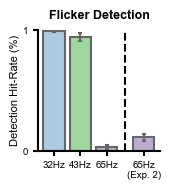

In [34]:
# set local defaults
cm = 1 / 2.54
img_style = {'title': dict(fontsize=9, fontweight='bold'),
             'axlabel': dict(fontsize=8),
             'ticklabel': dict(fontsize=7, color='black')}

# plot
f, ax = plt.subplots(1, 1, figsize=(4*cm, 4*cm))
percept_palette = dict([(0, np.array([172, 202, 226])/255),
                        (1, np.array([157, 215, 157])/255),
                        (2, np.array([190, 173, 211])/255)])

# plot bar
for label, j in zip(['32Hz_detect', '43Hz_detect', '65Hz_detect'], [0, 1, 2]):
    ax.bar(j, np.mean(group_data[0][label]), color=percept_palette[j], edgecolor=[0.4, 0.4, 0.4], capsize=2, linewidth=1.5)
    ax.errorbar(j, np.mean(group_data[0][label]), yerr=stats.sem(group_data[0][label]), ecolor=[0.4, 0.4, 0.4], capsize=1.5,
                   capthick=1.5, elinewidth=1.5)
    del label, j

ax.bar(3.4, np.mean(group_data[1]['detection']), color=percept_palette[2], edgecolor=[0.4, 0.4, 0.4], capsize=2,
       linewidth=1.5)
ax.errorbar(3.4, np.mean(group_data[1]['detection']), yerr=stats.sem(group_data[1]['detection']), ecolor=[0.4, 0.4, 0.4],
            capsize=1.5, capthick=1.5, elinewidth=1.5)

ax.set_ylim([0, 1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([0, 1, 2, 3.4])
ax.set_yticks([0, 1])
ax.axvline(2.7, color='k', linestyle='--')
ax.set_xticklabels(['32Hz', '43Hz', '65Hz', '65Hz\n(Exp. 2)'], **img_style['ticklabel'])
ax.set_yticklabels(['0', '1'], **img_style['ticklabel'])
ax.set_ylabel('Detection Hit-Rate (%)', labelpad=2, **img_style['axlabel'])
ax.set_title('Flicker Detection', pad=8, **img_style['title'])

plt.savefig("{}/figures/fig1_flickerDetection.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy up
del f, ax, percept_palette, cm, img_style, group_data, n_pp

## Section 4: Subprocess Analysis
As always, we begin by defining the key variables.

In [35]:
# define flicker/model labels
flicker_freqs = [65, 43, 33, 0]
labels_outcome = ['DM', 'WM']
labels_frequency = ['{}Hz_{}'.format(n, s) for n in [33, 43, 65] for s in ['encoding', 'retrieval']]
labels_predictor = labels_frequency + ['enc_onset', 'intercept']

# define number of participants/frequencies/models etc.
n_outcomes = np.size(labels_outcome, 0)
n_pp = 43
n_freqs = 4
n_predictors = np.size(labels_predictor, 0)

### Section 4.1: Single Participant Example
Here, we run through an example using participant 1. First, we read in the data and drop trials that are missing data

In [36]:
# define participant
pp = 0

# load data
filename = '{}/dataset-03/log_pp{:02.0f}.csv'.format(data_directory, pp + 1)
data = pd.read_csv(filename)
del filename

# identify trials with missing data
noResponse = data.task.isnull()

# drop trials with missing data
data = data.drop(index=np.where(noResponse)[0])
data = data.reset_index(drop=True)
del noResponse

We prepare our predictor variables for the logistic model

In [37]:
# z-score time-based parameters
data['enc_onset'] = stats.zscore(data['enc_onset'])

# dummy code flicker frequencies (excluding last value to avoid rank deficiency)
labels_frequency = []  # predefine list for regression predictors
for freq in np.arange(0, np.size(flicker_freqs) - 1):
    label = '{}Hz_encoding'.format(flicker_freqs[freq])  # define dataframe header
    data[label] = (data.enc_freq == (freq + 1)).astype('int')  # get binary match to target freq
    labels_frequency.append(label)  # add label to predictor list
    del freq, label

Then we run our logistic model (all of this is very much the same as in the main experiment)

In [38]:
# get subdata
subdata = data[data['task'] == 'DM']
del data

# run logistic regression for memory recall
predictors = labels_frequency + ['enc_onset']
t_values, labels = run_regression(subdata, predictors, 'correct', recalledOnly=False, useLogit=True)

# report
print("In task DM, predictor '{:s}': participant t = {:03.3f}".format(labels[0], t_values[0]))
del predictors, labels_frequency, subdata

In task DM, predictor '65Hz_encoding': participant t = -0.478


### Section 4.2: The Big Loop
Here, we run the analysis for all participants and models

In [39]:
# create group descriptives structure
group_means = pd.DataFrame(index=np.arange(0, np.sum(n_pp)), columns=['pp', 'DM', 'WM'])

# add in dataset/participant/model number
group_means['pp'] = np.arange(0, n_pp)

# create group data structure
group_models = pd.DataFrame(index=np.arange(0, n_pp * n_outcomes * n_predictors),
                                columns=['pp', 'outcome', 'predictor', 'regressor_t', 'outlier'])

# add in dataset/participant/model number
group_models['pp'] = np.repeat(np.arange(0, n_pp), n_outcomes * n_predictors)
group_models['outcome'] = np.tile(np.repeat(labels_outcome, n_predictors), n_pp)
group_models['predictor'] = np.tile(labels_predictor, n_pp * n_outcomes)

# cycle through participants
for pp in np.arange(0, n_pp):

    # load data
    filename = '{}/dataset-03/log_pp{:02.0f}.csv'.format(data_directory, pp + 1)
    data = pd.read_csv(filename)
    del filename

    # identify trials with missing data
    noResponse = data.task.isnull()

    # drop trials with missing data
    data = data.drop(index=np.where(noResponse)[0])
    data = data.reset_index(drop=True)
    del noResponse

    # store descriptives
    idx = np.where(group_means['pp'] == pp)[0]
    group_means.loc[idx, 'DM'] = data['correct'][np.where(data['task'] == 'DM')[0]].mean()
    group_means.loc[idx, 'WM'] = data['correct'][np.where(data['task'] == 'WM')[0]].mean()
    del idx

    # z-score time-based parameters
    data['enc_onset'] = stats.zscore(data['enc_onset'])

    # dummy code flicker frequencies (excluding last value to avoid rank deficiency)
    labels_frequency = []  # predefine list for regression predictors
    for freq in np.arange(0, np.size(flicker_freqs) - 1):
        label = '{}Hz_encoding'.format(flicker_freqs[freq])  # define dataframe header
        data[label] = (data.enc_freq == (freq + 1)).astype('int')  # get binary match to target freq
        labels_frequency.append(label)  # add label to predictor list
        del label, freq

    # cycle through models
    for model in np.arange(0, 2):

        # get subdata
        if model == 0:
            subdata = data[data['task'] == 'DM']
        else:
            subdata = data[data['task'] == 'WM']

        # run logistic regression for memory recall
        predictors = labels_frequency + ['enc_onset']
        t_values, labels = run_regression(subdata, predictors, 'correct', recalledOnly=False, useLogit=True)
        del predictors, subdata

        # add regressor results to group data
        for i, j in zip(t_values, labels):
            row_index = np.where((group_models['pp'] == pp) &
                                 (group_models['outcome'] == labels_outcome[model]) &
                                 (group_models['predictor'] == j))[0]
            column_index = np.where(group_models.columns == 'regressor_t')[0]
            group_models.iloc[row_index, column_index] = i

            # tidy loop variables
            del row_index, column_index, i, j

        # tidy loop variables
        del t_values, labels, model

    # tidy workspace
    del labels_frequency, data, pp
del flicker_freqs

We can then return descriptives...

In [40]:
print('WM Performance: {:2.1f} (s.d. {:2.1f})'.format(np.mean(group_means['WM']*100), np.std(group_means['WM']*100)))
print('DM Performance: {:2.1f} (s.d. {:2.1f})'.format(np.mean(group_means['DM']*100), np.std(group_means['DM']*100)))
del group_means

WM Performance: 96.2 (s.d. 5.0)
DM Performance: 75.9 (s.d. 26.8)


...run the statistical analysis...

In [41]:
# predefine statistics output
result_column_labels = ['outcome', 'predictor', 'mean', 'sem', 'd', 't', 'df', 'p', 'tost_pval', 'tost_tupp', 'tost_lupp']
results = pd.DataFrame(index=np.arange(0, n_outcomes * n_predictors),
                           columns=result_column_labels)
results['outcome'] = np.repeat(labels_outcome, n_predictors)
results['predictor'] = np.tile(labels_predictor, n_outcomes)
del result_column_labels

# define side of tail
tail = ['greater', 'greater', 'greater']

# cycle through outcomes and predictors
for outcome in labels_outcome:
    for predictor in labels_predictor:

        # get data for dataset/model
        sub_models = group_models.query("outcome == '{}' and predictor == '{}'".format(outcome, predictor)).reset_index\
            (drop=True)

        # skip if all values are NaN
        if all(np.isnan(sub_models['regressor_t'].values.astype('float'))): # skip if empty
            continue

        # get data of interest
        values = sub_models['regressor_t'].astype('float')
        values = values.dropna().reset_index(drop=True)
        del sub_models

        # get index in results DataFrame
        row_index = np.where((results['outcome'] == outcome) & (results['predictor'] == predictor))[0]

        # get regressor descriptives
        results.loc[row_index, 'mean'] = np.mean(values)
        results.loc[row_index, 'sem'] = np.std(values) / np.sqrt(np.size(values))
        results.loc[row_index, 'd'] = np.mean(values) / np.std(values)

        # run t-test
        results.loc[row_index, 'df'] = np.size(values, axis=0) - 1  # get degrees of freedom
        results.loc[row_index, 't'], results.loc[row_index, 'p'] = stats.ttest_1samp(values, 0, alternative='greater')

        # run TOST
        thr = np.std(values) * 0.5
        [p, t1, t2] = weightstats.ttost_paired(values, np.zeros(np.size(values)), -thr, thr)
        results.loc[row_index, 'tost_pval'] = p
        results.loc[row_index, 'tost_tupp'] = t1[0]
        results.loc[row_index, 'tost_lupp'] = t2[0]
        del row_index, p, t1, t2, values, predictor, thr
    del outcome

# drop contrasts with NaN results
results = results.dropna(axis=0, how='any', inplace=False)
results = results.reset_index(drop=True, inplace=False)

# return results
print(results)
del tail, results, n_freqs, n_outcomes, n_pp, n_predictors, labels_outcome, labels_predictor

  outcome      predictor      mean       sem         d         t  df  \
0      DM  33Hz_encoding   0.00335  0.127169   0.00433  0.025981  36   
1      DM  43Hz_encoding -0.019592  0.120622 -0.026702 -0.160214  36   
2      DM  65Hz_encoding -0.125787  0.112381 -0.184011 -1.104065  36   
3      DM      enc_onset  0.504526  0.254216  0.326272  1.957633  36   
4      DM      intercept  0.882484  0.274392  0.528731  3.172383  36   
5      WM  33Hz_encoding  0.012567  0.048236   0.04069  0.257343  40   
6      WM  43Hz_encoding  0.013012  0.046563  0.043642  0.276017  40   
7      WM  65Hz_encoding   0.02101  0.066418  0.049402  0.312443  40   
8      WM      enc_onset -0.265483  0.167013 -0.248253 -1.570091  40   
9      WM      intercept  1.576838  0.249295  0.987829  6.247579  40   

          p tost_pval tost_tupp tost_lupp  
0  0.489708   0.00261  3.025981 -2.974019  
1  0.563196   0.00369  2.839786 -3.160214  
2  0.861555  0.033009  1.895935 -4.104065  
3   0.02903  0.152096  4.957633

...plot the short-term memory results...

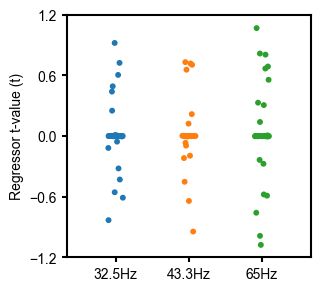

In [42]:
# set local defaults
cm = 1 / 2.54

values = [[], [], []]
for n, predictor in enumerate(['33Hz_encoding', '43Hz_encoding', '65Hz_encoding']):

    # get data for dataset/model
    sub_models = group_models.query("outcome == 'WM' and predictor == '{}'".format(predictor)).reset_index(drop=True)

    # skip if all values are NaN
    if all(np.isnan(sub_models['regressor_t'].values.astype('float'))): # skip if empty
        continue

    # get data of interest
    values[n] = sub_models['regressor_t'].astype('float')
    values[n] = values[n].dropna().reset_index(drop=True) # drop missing values
    del sub_models, n, predictor

fig, ax = plt.subplots(1, 1, figsize=(8*cm, 8*cm))
for n in range(3):
    nppi = np.size(values[n])
    ax.scatter(x=np.zeros(nppi)+n+((np.random.rand(nppi)-0.5)/5), y=values[n], s=18, edgecolors='none')
    del n, nppi
ax.set_xlim([-2/3, 2+2/3])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['32.5Hz', '43.3Hz', '65Hz'])
ax.set_yticks([-1.2, -0.6, 0, 0.6, 1.2])
ax.set_ylabel('Regressor t-value (t)')

plt.savefig("{}/figures/supp_figure1a.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

del fig, ax, values

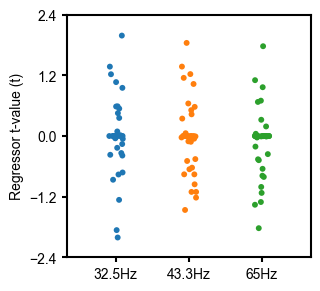

In [43]:
values = [[], [], []]
for n, predictor in enumerate(['33Hz_encoding', '43Hz_encoding', '65Hz_encoding']):

    # get data for dataset/model
    sub_models = group_models.query("outcome == 'DM' and predictor == '{}'".format(predictor)).reset_index(drop=True)

    # skip if all values are NaN
    if all(np.isnan(sub_models['regressor_t'].values.astype('float'))): # skip if empty
        continue

    # get data of interest
    values[n] = sub_models['regressor_t'].astype('float')
    values[n] = values[n].dropna().reset_index(drop=True) # drop missing values

    # tidy up
    del predictor, n, sub_models

fig, ax = plt.subplots(1, 1, figsize=(8*cm, 8*cm))
for n in range(3):
    nppi = np.size(values[n])
    ax.scatter(x=np.zeros(nppi)+n+((np.random.rand(nppi)-0.5)/5), y=values[n], s=18, edgecolors='none')
    del n, nppi
ax.set_xlim([-2/3, 2+2/3])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['32.5Hz', '43.3Hz', '65Hz'])
ax.set_yticks([-2.4, -1.2, 0, 1.2, 2.4])
ax.set_ylabel('Regressor t-value (t)')

plt.savefig("{}/figures/supp_figure1b.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

del ax, fig, cm, values, group_models